In [1]:
using Printf, CSV, DataFrames, Statistics, Glob, XLSX, Dates, Plots, TimeSeries, JSON, Distributions, ExpectationMaximization

In [2]:
data_directory = joinpath("/projects", "emco4286", "data", "gads", "trajectories", "cc")
files = glob("gen_*_class_CC_rating_*_state_Texas.csv", data_directory)

263-element Vector{String}:
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_3_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 26 bytes ⋯ "ass_CC_rating_1_state_Texas.csv"
 ⋮
 "/projects/emco4286/data/gads/tr" ⋯ 25 bytes ⋯ "ass_CC_rating_2_state_Texas.csv"
 "/projects/emco4286/data/gads/tr" ⋯ 25 bytes ⋯ "ass_CC_rating_1_st

In [3]:
ph = 8760
foh = 513.343
num_fo = 7.461
poh = 634.662
num_po = 1.799
moh = 183.775
num_mo = 2.78

fo_ttf_rate = (ph - moh - poh)/num_fo
po_ttf_rate = (ph - moh - foh)/num_po
mo_ttf_rate = (ph - foh - poh)/num_mo

@printf "TTF FO: %0.2f hours\n" fo_ttf_rate
@printf "TTF PO: %0.2f hours\n" po_ttf_rate
@printf "TTF MO: %0.2f hours\n" mo_ttf_rate

TTF FO: 1064.41 hours
TTF PO: 4481.87 hours
TTF MO: 2738.13 hours


In [4]:
ttf_values_fo_vec = Any[]
ttr_values_fo_vec = Any[]

ttf_values_po_vec = Any[]
ttr_values_po_vec = Any[]

ttf_values_mo_vec = Any[]
ttr_values_mo_vec = Any[]

outage_types_vec = []

for f in files

    df = DataFrame(CSV.File(f))

    if size(df)[1] < 1
        continue
    end

    outage_start = findall(diff(df[!, :y1]) .== -1)
    outage_end = findall(diff(df[!, :y1]) .== 1)

    if length(outage_end) < length(outage_start)
        outage_start = outage_start[begin: end-1]
    elseif length(outage_end) > length(outage_start)
        outage_end = outage_end[begin + 1: end]
    end

    ttr_values = outage_end .- outage_start
    ttf_values_all_types = outage_start[begin + 1: end] - outage_end[begin:end - 1]

    outage_types = df[outage_start .+ 1, :y2]
    push!(outage_types_vec, outage_types)
    
    fo_idx = findall(outage_types .== 2)
    os_fo = outage_start[fo_idx]
    oe_fo = outage_end[fo_idx]

    fo_idx_mod = filter(x -> x > 0, fo_idx .- 1)

    ttf_values_fo = os_fo[begin + 1: end] - oe_fo[begin:end - 1] # ttf_values_all_types[fo_idx_mod]
    ttr_values_fo = ttr_values[fo_idx]

    push!(ttf_values_fo_vec, ttf_values_fo)
    push!(ttr_values_fo_vec, ttr_values_fo)

    po_idx = findall(outage_types .== 3)
    os_po = outage_start[po_idx]
    oe_po = outage_end[po_idx]

    po_idx_mod = filter(x -> x > 0, po_idx .- 1)

    ttf_values_po = os_po[begin + 1: end] - oe_po[begin:end - 1] # ttf_values_all_types[po_idx_mod]
    ttr_values_po = ttr_values[po_idx]

    push!(ttf_values_po_vec, ttf_values_po)
    push!(ttr_values_po_vec, ttr_values_po)

    mo_idx = findall(outage_types .== 4)
    os_mo = outage_start[mo_idx]
    oe_mo = outage_end[mo_idx]

    mo_idx_mod = filter(x -> x > 0, mo_idx .- 1)

    ttf_values_mo = os_mo[begin + 1: end] - oe_mo[begin:end - 1] # ttf_values_all_types[mo_idx_mod]
    # ttf_values_mo = os_mo[begin + 1: end] - oe_mo[begin:end - 1]
    ttr_values_mo = ttr_values[mo_idx]

    push!(ttf_values_mo_vec, ttf_values_mo)
    push!(ttr_values_mo_vec, ttr_values_mo)

end

In [6]:
a = reduce(vcat, outage_types_vec)
total = sum([count(==(element),a) for element in unique(a) ])
my_dict = Dict([element => count(==(element),a) for element in unique(a)])

fo_proportion = (my_dict[2.0])/total
po_proportion = my_dict[3.0]/total
mo_proportion = my_dict[4.0]/total

0.23397939584424654

In [7]:
ttr_values_fo_vec = reduce(vcat, ttr_values_fo_vec)
ttr_values_po_vec = reduce(vcat, ttr_values_po_vec)
ttr_values_mo_vec = reduce(vcat, ttr_values_mo_vec);

In [8]:
ttr_f = fit_mle(Exponential(1/foh), ttr_values_fo_vec)
ttr_p = fit_mle(Exponential(1/poh), ttr_values_po_vec)
ttr_m = fit_mle(Exponential(1/moh), ttr_values_mo_vec)

Exponential{Float64}(θ=69.8228855721393)

In [9]:
ttf_values_fo_vec = reduce(vcat, ttf_values_fo_vec)
ttf_values_po_vec = reduce(vcat, ttf_values_po_vec)
ttf_values_mo_vec = reduce(vcat, ttf_values_mo_vec);

In [10]:
ttf_f = fit_mle(Exponential(1/fo_ttf_rate), ttf_values_fo_vec)
ttf_p = fit_mle(Exponential(1/po_ttf_rate), ttf_values_po_vec)
ttf_m = fit_mle(Exponential(1/mo_ttf_rate), ttf_values_mo_vec);

In [11]:
@printf "TTF FO: %0.2f \n" ttf_f.θ
@printf "TTF PO: %0.2f \n" ttf_p.θ
@printf "TTF MO: %0.2f \n" ttf_m.θ

TTF FO: 1001.74 
TTF PO: 3636.19 
TTF MO: 2426.47 


In [12]:
all_ttf = reduce(vcat, [ttf_values_fo_vec, ttf_values_po_vec, ttf_values_mo_vec]);

In [13]:
mix_guess = MixtureModel([ttf_f, ttf_m, ttf_p], [fo_proportion, mo_proportion, po_proportion])
mix_mle, info = fit_mle(mix_guess, all_ttf, infos = true)

(MixtureModel{Exponential{Float64}}(K = 3)
components[1] (prior = 0.1125): Exponential{Float64}(θ=19.642778670698107)
components[2] (prior = 0.3881): Exponential{Float64}(θ=436.0201365492291)
components[3] (prior = 0.4994): Exponential{Float64}(θ=3143.2929818227517)
, Dict{String, Any}("iterations" => 185, "converged" => true, "logtots" => [-279177.4902382799, -278487.37421203405, -278095.0042432372, -277822.1227678845, -277608.28823983134, -277431.70218111435, -277282.5928241208, -277155.0352242413, -277044.64631448314, -276947.97358613525  …  -275263.0902122762, -275263.0874055865, -275263.0849602941, -275263.0828299818, -275263.08097417234, -275263.0793575718, -275263.0779494097, -275263.0767228621, -275263.0756545471, -275263.07472408534]))

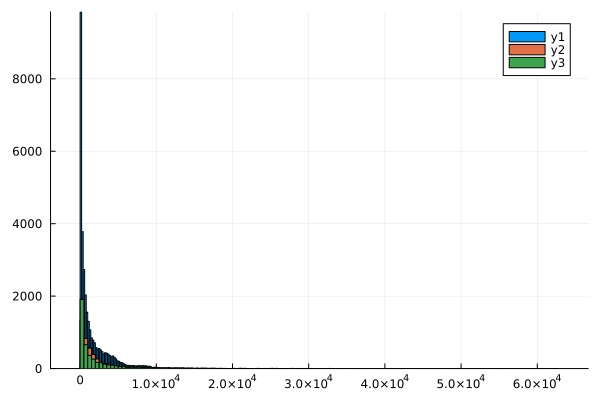

In [14]:
samples1 = rand(mix_guess, 4327)
samples2 = rand(mix_mle, 4327)
histogram([all_ttf, samples1, samples2])